# Natural Language Processing with Sequence Models

In [1]:
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, GRU, LSTM, Dense, Bidirectional, TimeDistributed
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

In [2]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

In [31]:
def plot_confusion_matrix(cm, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Greens):
	'''
	This function plot confusion matrix method from sklearn package.
	'''

	plt.figure(figsize= (10, 10))
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title)
	plt.colorbar()

	tick_marks = np.arange(10)
	plt.xticks(tick_marks, rotation= 45)
	plt.yticks(tick_marks)

	if normalize:
		cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
		print('Normalized Confusion Matrix')

	else:
		print('Confusion Matrix, Without Normalization')

	print(cm)

	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

	plt.tight_layout()
	plt.ylabel('True Label')
	plt.xlabel('Predicted Label')

In [4]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/conll003-englishversion/valid.txt
/kaggle/input/conll003-englishversion/metadata
/kaggle/input/conll003-englishversion/test.txt
/kaggle/input/conll003-englishversion/train.txt


# Load Data

In [5]:
def load_data(file_path):
    with open(file_path, "r") as f:
        lines = f.readlines()
        

    sentences, labels = [], []
    sentence, label = [], []

    for line in lines:
        if line == "\n" or line.startswith("-DOCSTART-"):
            if sentence and label:
                sentences.append(sentence)
                labels.append(label)
                sentence, label = [], []
        else:
            word, _, _, tag = line.strip().split()
            sentence.append(word.lower())  # Normalize the case
            label.append(tag)

    return sentences, labels

train_file_path = "../input/conll003-englishversion/train.txt"
valid_file_path= "../input/conll003-englishversion/valid.txt"
test_file_path = "../input/conll003-englishversion/test.txt"

train_sentences, train_labels = load_data(train_file_path)
valid_sentences, valid_labels = load_data(valid_file_path)
test_sentences, test_labels = load_data(test_file_path)

In [6]:
df = pd.DataFrame({
    "train_sentences":train_sentences,
    "train_labels":train_labels
})
df

,train_sentences,train_labels
0,"[eu, rejects, german, call, to, boycott, briti...","[B-ORG, O, B-MISC, O, O, O, B-MISC, O, O]"
1,"[peter, blackburn]","[B-PER, I-PER]"
2,"[brussels, 1996-08-22]","[B-LOC, O]"
3,"[the, european, commission, said, on, thursday...","[O, B-ORG, I-ORG, O, O, O, O, O, O, B-MISC, O,..."
4,"[germany, 's, representative, to, the, europea...","[B-LOC, O, O, O, O, B-ORG, I-ORG, O, O, O, B-P..."
...,...,...
14036,"[on, friday, :]","[O, O, O]"
14037,"[division, two]","[O, O]"
14038,"[plymouth, 2, preston, 1]","[B-ORG, O, B-ORG, O]"
14039,"[division, three]","[O, O]"


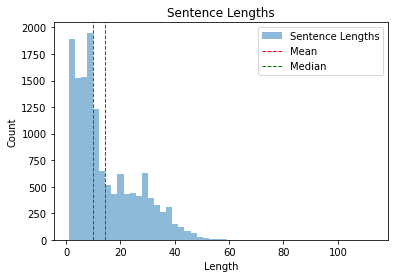

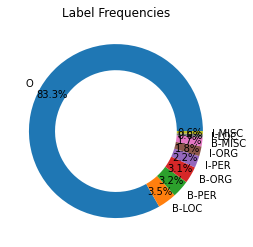

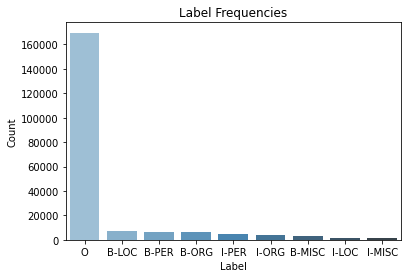

In [7]:

# Plot a histogram of the sentence lengths
sentence_lengths = [len(sentence) for sentence in df['train_sentences']]
plt.hist(sentence_lengths, bins=50, alpha=0.5, label='Sentence Lengths')
plt.axvline(np.mean(sentence_lengths), color='r', linestyle='dashed', linewidth=1, label='Mean')
plt.axvline(np.median(sentence_lengths), color='g', linestyle='dashed', linewidth=1, label='Median')
plt.title('Sentence Lengths')
plt.xlabel('Length')
plt.ylabel('Count')
plt.legend()
plt.show()

# Plot a donut chart of the label frequencies
label_counts = df['train_labels'].explode().value_counts()
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', pctdistance=0.85, wedgeprops=dict(width=0.3))
plt.title('Label Frequencies')
plt.show()

# Plot a bar chart of the label frequencies using seaborn
sns.barplot(x=label_counts.index, y=label_counts.values, palette="Blues_d")
plt.title('Label Frequencies')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [8]:
# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['train_sentences'])
sequences = tokenizer.texts_to_sequences(df['train_sentences'])
test_sequences = tokenizer.texts_to_sequences(test_sentences)
valid_sequences = tokenizer.texts_to_sequences(valid_sentences)
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(df['train_labels'])
label_sequences = label_tokenizer.texts_to_sequences(df['train_labels'])
test_label_sequences = label_tokenizer.texts_to_sequences(test_labels)
valid_label_sequences = label_tokenizer.texts_to_sequences(valid_labels)

# Padding
maxlen = max(len(s) for s in sequences)
X_train = pad_sequences(sequences, maxlen=maxlen, padding='post')
X_test = pad_sequences(test_sequences, maxlen=maxlen, padding='post')
X_valid = pad_sequences(valid_sequences, maxlen=maxlen, padding='post')
y_train = pad_sequences(label_sequences, maxlen=maxlen, padding='post')
y_test = pad_sequences(test_label_sequences, maxlen=maxlen, padding='post')
y_valid = pad_sequences(valid_label_sequences, maxlen=maxlen, padding='post')

## Build & Train Lstm

In [9]:
vocab_size = len(tokenizer.word_index) + 1
max_len = 50
embedding_dim = 100
hidden_units = 64
num_classes = len(label_tokenizer.word_index) + 1
batch_size = 32
num_epochs = 10

# Création du modèle
model1 = Sequential()
model1.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len))
model1.add(Bidirectional(LSTM(units=hidden_units, return_sequences=True)))
model1.add(TimeDistributed(Dense(num_classes, activation='softmax')))

# Compilation du modèle
model1.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [10]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 100)           2101000   
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 128)           84480     
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 10)            1290      
Total params: 2,186,770
Trainable params: 2,186,770
Non-trainable params: 0
_________________________________________________________________


In [11]:
history1 = model1.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_data=(X_valid, y_valid))

Epoch 1/10
439/439 [==============================] - 14s 17ms/step - loss: 0.1623 - accuracy: 0.9675 - val_loss: 0.1636 - val_accuracy: 0.9686
Epoch 2/10
439/439 [==============================] - 7s 15ms/step - loss: 0.0415 - accuracy: 0.9885 - val_loss: 0.2027 - val_accuracy: 0.9727
Epoch 3/10
439/439 [==============================] - 7s 15ms/step - loss: 0.0181 - accuracy: 0.9953 - val_loss: 0.2295 - val_accuracy: 0.9742
Epoch 4/10
439/439 [==============================] - 7s 15ms/step - loss: 0.0096 - accuracy: 0.9976 - val_loss: 0.2515 - val_accuracy: 0.9745
Epoch 5/10
439/439 [==============================] - 7s 15ms/step - loss: 0.0058 - accuracy: 0.9985 - val_loss: 0.2600 - val_accuracy: 0.9749
Epoch 6/10
439/439 [==============================] - 7s 16ms/step - loss: 0.0037 - accuracy: 0.9991 - val_loss: 0.2703 - val_accuracy: 0.9749
Epoch 7/10
439/439 [==============================] - 7s 15ms/step - loss: 0.0026 - accuracy: 0.9993 - val_loss: 0.2806 - val_accuracy: 0.975

## Build & Traib GRU

In [12]:
# Define the model
model2 = Sequential()
model2.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=64, input_length=maxlen))
model2.add(GRU(units=64, return_sequences=True))
model2.add(TimeDistributed(Dense(len(label_tokenizer.word_index)+1, activation='softmax')))

# Compile the model
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [13]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 113, 64)           1344640   
_________________________________________________________________
gru (GRU)                    (None, 113, 64)           24960     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 113, 10)           650       
Total params: 1,370,250
Trainable params: 1,370,250
Non-trainable params: 0
_________________________________________________________________


In [14]:
history2 = model2.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_data=(X_valid, y_valid))

Epoch 1/10
439/439 [==============================] - 6s 9ms/step - loss: 0.2076 - accuracy: 0.9597 - val_loss: 0.1602 - val_accuracy: 0.9676
Epoch 2/10
439/439 [==============================] - 3s 8ms/step - loss: 0.0468 - accuracy: 0.9860 - val_loss: 0.1875 - val_accuracy: 0.9713
Epoch 3/10
439/439 [==============================] - 4s 8ms/step - loss: 0.0253 - accuracy: 0.9939 - val_loss: 0.2075 - val_accuracy: 0.9736
Epoch 4/10
439/439 [==============================] - 4s 8ms/step - loss: 0.0137 - accuracy: 0.9966 - val_loss: 0.2208 - val_accuracy: 0.9741
Epoch 5/10
439/439 [==============================] - 4s 8ms/step - loss: 0.0092 - accuracy: 0.9974 - val_loss: 0.2346 - val_accuracy: 0.9742
Epoch 6/10
439/439 [==============================] - 4s 8ms/step - loss: 0.0071 - accuracy: 0.9979 - val_loss: 0.2396 - val_accuracy: 0.9744
Epoch 7/10
439/439 [==============================] - 4s 8ms/step - loss: 0.0058 - accuracy: 0.9982 - val_loss: 0.2454 - val_accuracy: 0.9738
Epoch 

# Build & Train RNN

In [15]:
# Define the model
model3 = Sequential()
model3.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=64, input_length=maxlen))
model3.add(SimpleRNN(units=64, return_sequences=True))
model3.add(TimeDistributed(Dense(len(label_tokenizer.word_index)+1, activation='softmax')))

# Compile the model
model3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [16]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 113, 64)           1344640   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 113, 64)           8256      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 113, 10)           650       
Total params: 1,353,546
Trainable params: 1,353,546
Non-trainable params: 0
_________________________________________________________________


In [17]:
history3 = model3.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_data=(X_valid, y_valid))

Epoch 1/10
439/439 [==============================] - 41s 91ms/step - loss: 0.1959 - accuracy: 0.9502 - val_loss: 0.1465 - val_accuracy: 0.9694
Epoch 2/10
439/439 [==============================] - 40s 91ms/step - loss: 0.0489 - accuracy: 0.9875 - val_loss: 0.1728 - val_accuracy: 0.9727
Epoch 3/10
439/439 [==============================] - 40s 91ms/step - loss: 0.0234 - accuracy: 0.9949 - val_loss: 0.1917 - val_accuracy: 0.9740
Epoch 4/10
439/439 [==============================] - 39s 90ms/step - loss: 0.0122 - accuracy: 0.9971 - val_loss: 0.2079 - val_accuracy: 0.9743
Epoch 5/10
439/439 [==============================] - 40s 90ms/step - loss: 0.0078 - accuracy: 0.9980 - val_loss: 0.2226 - val_accuracy: 0.9746
Epoch 6/10
439/439 [==============================] - 40s 90ms/step - loss: 0.0056 - accuracy: 0.9985 - val_loss: 0.2343 - val_accuracy: 0.9746
Epoch 7/10
439/439 [==============================] - 39s 90ms/step - loss: 0.0044 - accuracy: 0.9988 - val_loss: 0.2445 - val_accuracy:

# Evaluation

Model: LSTM


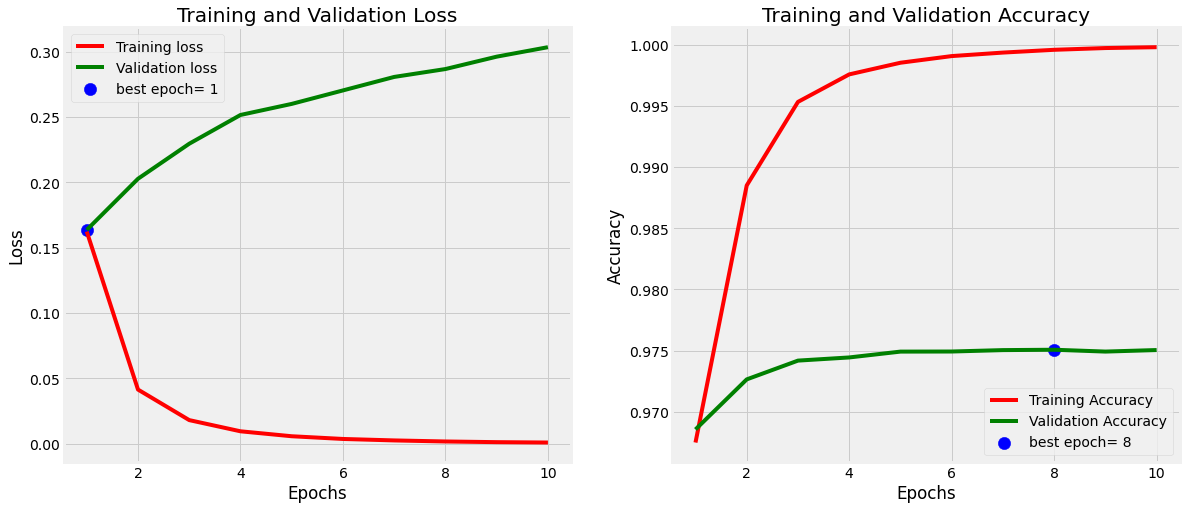

Model: GRU


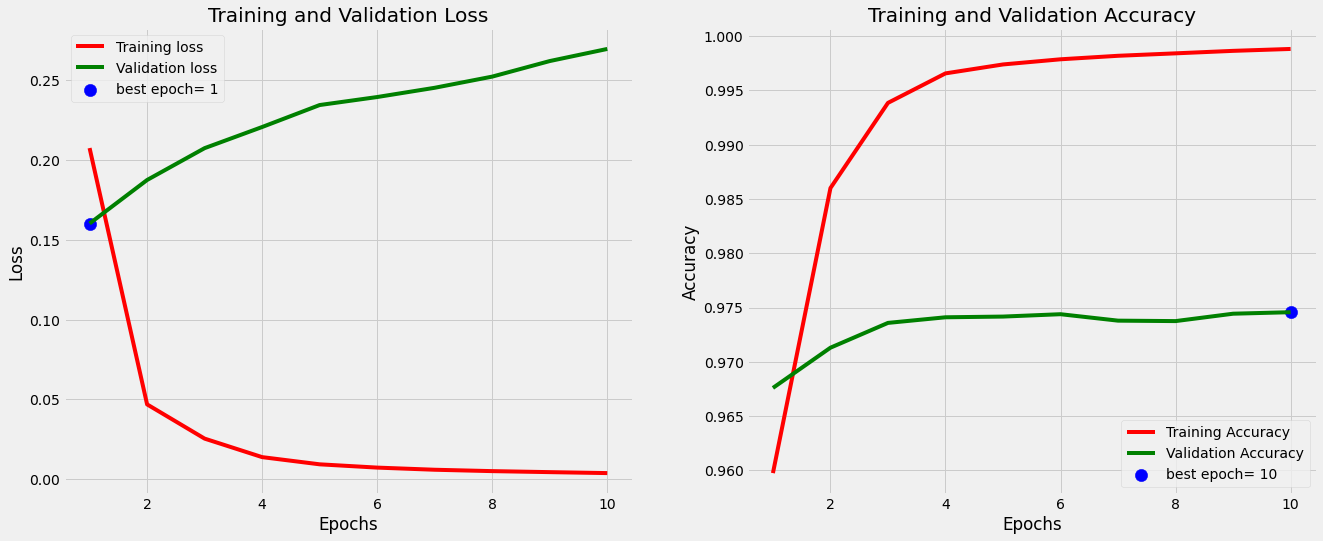

Model: RNN


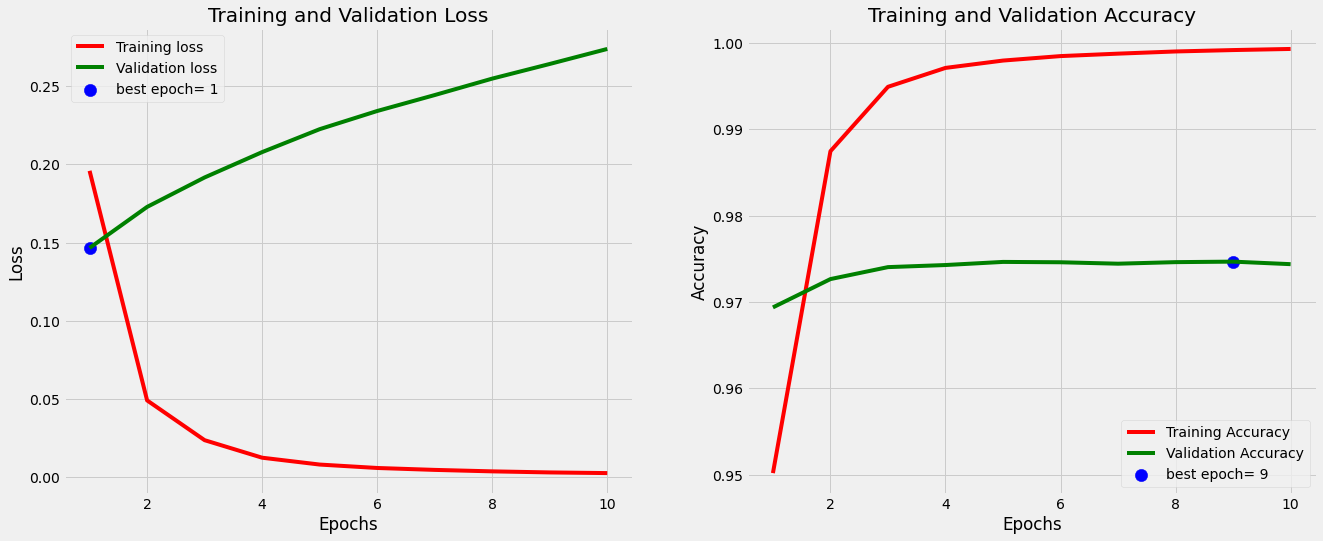

In [18]:
history = [history1, history2, history3]
model= ['LSTM','GRU','RNN']

for his, mod in zip(history, model):
    print(f'Model: {mod}')
    plot_training(his)

In [19]:
models = [model1, model2, model3]
model_names = ['LSTM','GRU','RNN']

for model, model_name in zip(models, model_names):
    ts_length = len(X_test)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size

    train_score = model.evaluate(X_train,y_train, steps= test_steps, verbose= 1)
    valid_score = model.evaluate(X_valid,y_valid, steps= test_steps, verbose= 1)
    test_score = model.evaluate(X_test,y_test,  steps= test_steps, verbose= 1)
    print(f"===========Model: {model_name}==============" )
    print("Train Loss: ", train_score[0])
    print("Train Accuracy: ", train_score[1])
    print('-' * 20)
    print("Validation Loss: ", valid_score[0])
    print("Validation Accuracy: ", valid_score[1])
    print('-' * 20)
    print("Test Loss: ", test_score[0])
    print("Test Accuracy: ", test_score[1])
    print("=========================" )

1151/1151 [==============================] - 7s 5ms/step - loss: 0.3430 - accuracy: 0.9718
===========Model: LSTM==============
Train Loss:  0.0006832318031229079
Train Accuracy:  0.9998733401298523
--------------------
Validation Loss:  0.30332890152931213
Validation Accuracy:  0.9750551581382751
--------------------
Test Loss:  0.3430158197879791
Test Accuracy:  0.9718188047409058
1151/1151 [==============================] - 4s 3ms/step - loss: 0.3028 - accuracy: 0.9714
===========Model: GRU==============
Train Loss:  0.0030807119328528643
Train Accuracy:  0.9990193247795105
--------------------
Validation Loss:  0.26976391673088074
Validation Accuracy:  0.9745704531669617
--------------------
Test Loss:  0.30280449986457825
Test Accuracy:  0.9713625907897949
1151/1151 [==============================] - 12s 10ms/step - loss: 0.3052 - accuracy: 0.9712
===========Model: RNN==============
Train Loss:  0.0018666430842131376
Train Accuracy:  0.9994869828224182
--------------------
Validat

LSTM:
Accuracy: 0.9718187852553506
Precision: 0.9686556953318787
Recall: 0.9718187852553506
F1-score: 0.9694959280927841
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    343765
           1       0.90      0.84      0.87     38316
           2       0.46      0.43      0.45      1667
           3       0.56      0.30      0.39      1616
           4       0.68      0.51      0.59      1660
           5       0.55      0.16      0.25      1155
           6       0.62      0.39      0.48       835
           7       0.50      0.45      0.47       702
           8       0.51      0.46      0.48       257
           9       0.41      0.35      0.38       216

    accuracy                           0.97    390189
   macro avg       0.62      0.49      0.54    390189
weighted avg       0.97      0.97      0.97    390189

Confusion Matrix, Without Normalization
[[343765      0      0      0      0      0      0      0

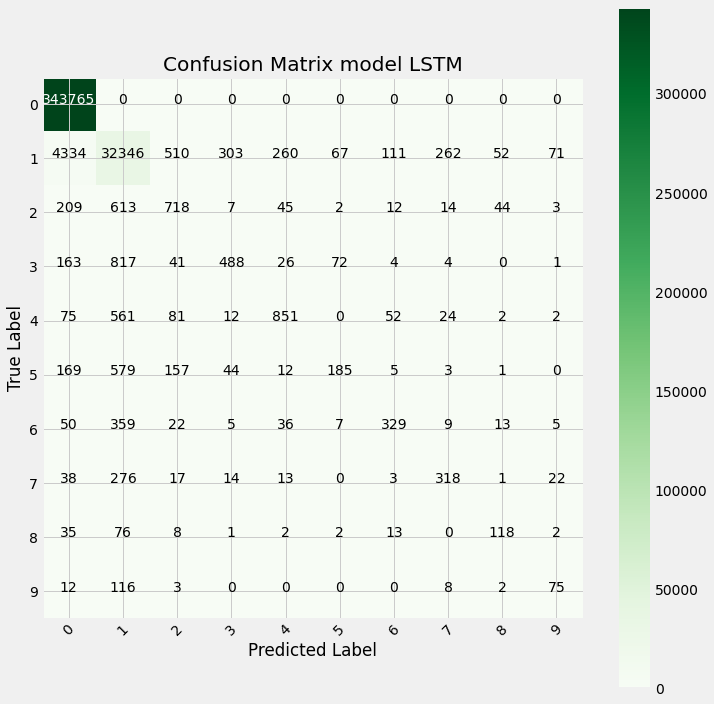

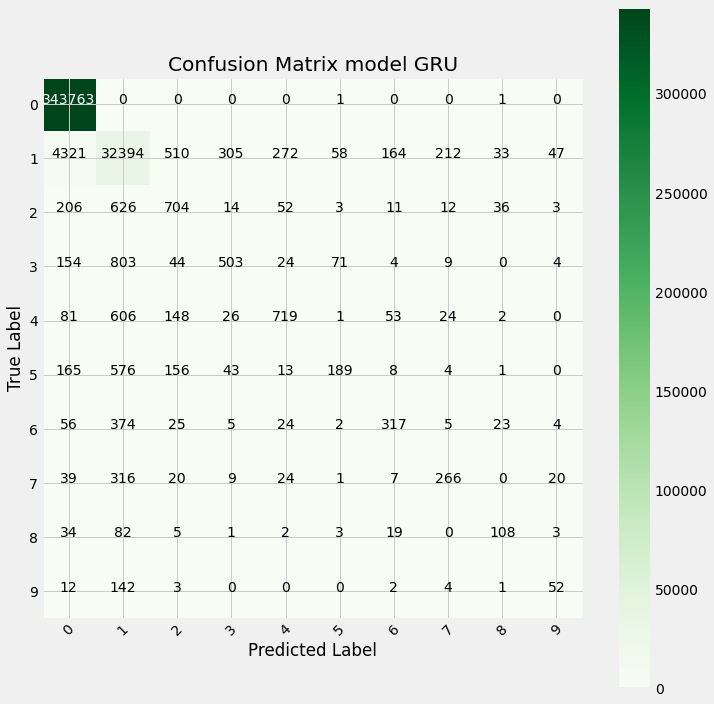

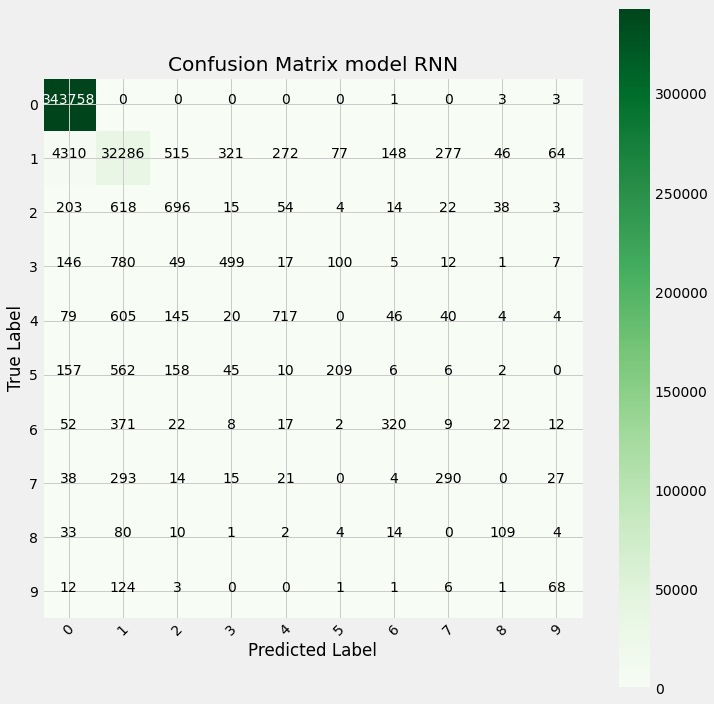

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# List of models and their names
models = [(model1, 'LSTM'), (model2, 'GRU'), (model3, 'RNN')]

for model, name in models:
    # Generate predictions
    y_pred = model.predict(X_test)

    # Convert probabilities to class labels
    y_pred = np.argmax(y_pred, axis=-1)

    # Flatten the predicted and true values
    y_pred = y_pred.flatten()
    y_test_flattened = y_test.flatten()

    # Calculate metrics
    accuracy = accuracy_score(y_test_flattened, y_pred)
    precision = precision_score(y_test_flattened, y_pred, average='weighted')
    recall = recall_score(y_test_flattened, y_pred, average='weighted')
    f1 = f1_score(y_test_flattened, y_pred, average='weighted')

    # Print metrics
    print(f'{name}:')
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1-score: {f1}')

    # Generate a classification report
    report = classification_report(y_test_flattened, y_pred)
    print('Classification Report:')
    print(report)

    # Generate a confusion matrix
    cm = confusion_matrix(y_test_flattened, y_pred)
    plot_confusion_matrix(cm=cm, title=f'Confusion Matrix model {name}')
    print("===============================")
    print('\n')